# Wiener Mask estimation using a deep neural network

# Introduction
Nowadays, spatial audio finds many use cases, from virtual reality [1,2] all the way to aids for the hearing impaired [3]. Spatial audio allows the listener to experience auditory scenes equivalent to daily sonic experiences. The sound we experience in everyday life carries, in addition to the temporal (tone) information, spatial information regarding the source's distance and direction relative to the listener. So in order to generate a convincing acoustic experience, it is necessary to be able to capture and preserve the spatial information of the sound. Spherical microphone arrays can capture spatial audio using the well-established Ambisonics format [4]. Nevertheless, even with high-quality recording systems, the sound field in the real world may include, in addition to desired components such as speech or music, also undesired components such as noise or other interferences. 

In a recent study [5], three methods to attenuate the undesired components without distorting the spatial information in the desired components were presented and shown to work well in various scenarios. These methods are based on spatial and time-frequency Wiener masking [6] of the signals recorded by the spherical microphone array. The filtering masks are calculated in the paper, assuming that the instantaneous SNR information is known and available. However, in a practical case, the instantaneous SNR is not available and needs to be estimated.

This final project aims to estimate the Wiener masks using Deep Neural Networks (DNNs) without an a priori knowledge.

**The goals of our work:**
1. Generate a Data set, which is comprised of desired sources (speakers) and noise.
2. Implement the benchmark so that we can compare our method results.
3. Building a suitable network to the considered problem and tune its parameters to get high-performance results.

# Dataset

###**Mathematical discription**

The recording is simulated in MATLAB, and consists of a spherical microphone array placed in a shoe-box-shaped room. Two sound sources will be placed in the room, the first of a human speaker, the second will transmit noise. The reverberant sound pressure is captured by the $L$ microphones located on the spherical microphone array. Each microphone producing a $N \, X \, 1$ vector, which represents the pressure at the $l$'th microphone position, denoted as $\mathbf{p}_l(t)$, where $t$ is the time index. We assume $\mathbf{p}_l(t)$ is sampled at a sampling frequency $f_s$. The array simultaneously outputs $L$ channels, each corresponds with one of the array microphones. Next, the channels undergo a Spherical Harmonics Decomposition (SHD) [7], Short Time Fourier Transform (STFT) and a Inverse Spherical Fourier Transform (ISFT) [8], Resulting in $\mathbf{a}(\mathbf{\Phi},\tau,\nu)$ a $Q \, X \, 1$ vector of the Plane-Wave Density (PWD) function at $\mathbf{\Phi} = [\Phi_1, ..., \Phi_Q]$ arbitrary directions. $\mathbf{a}(\mathbf{\Phi},\tau,\nu)$ is effectively a tensor with $\mathbf{\Phi}$ represents space, $\tau$ represents time and $\nu$ frequency where each entry is a complex number. The tensor will be the input of the learning model. Refer to Figure 1 for a block-diagram illustration of the simulation.



The whole process is repeated without the noise source, resulting in $\mathbf{a_{d}}(\mathbf{\Phi},\tau,\nu)$ and again without the human speaker, resulting in $\mathbf{a_{u}}(\mathbf{\Phi},\tau,\nu)$. Finally, the instantaneous SNR matrix for every $q$-th direction is calculated by:
\begin{equation}
SNR(\Phi_q,\tau,\nu)= \frac{|a_d(\Phi_q,\tau,\nu)|^2}{|a_u(\Phi_q,\tau,\nu)|^2}
\end{equation}
The target tensor of the learning model is the Wiener masks defined as:
\begin{equation}
\frac{SNR(\mathbf{\Phi},\tau,\nu)}{SNR(\mathbf{\Phi},\tau,\nu) +1}
\end{equation}
which is composed of Q matrices, see Figure 2. 

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1jZRx4NOMJetwhhNEKlbIB2UeTfuWeFU7' />
<figcaption>Fig.1: input system diagram</figcaption></center>
</figure>

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1sVdG9MgV9FICux8SYBMqJgYE1qYpjBMo' />
<figcaption>Fig.2: target system diagram</figcaption></center>
</figure>
 

###**Matlab: dataset generation**
A data set can be generated by simulating input/target pairs for different simulation parameters, resulting in a rich data set that will hopefully represent the true distribution of the scenario. The simulation parameters include:

 1. sources and recording array position
 
 2. noise source type
 
 3. various human speakers
 
 4. SNR
 
 5. room parameters
 
 6. STFT parameters
 
 7. number of microphones on the array


 
In practice, for each data point (an array of $Q$ matrices), we changed the sources and noise position, noise parameters (type, synthesized/real-world noise, bandwidth), various human speakers, and SNR values.

The room parameters, STFT parameters, and the number of microphones on the array are kept constant.


STFT parameters are as follows:

* window type = Hanning 
* window size = 512
* length of FFT = 512
* overlap sample size = 256
* number of time bins in STFT = 160.

room parameters (which relate to the reverberative character of the room):
* room dimensions = [8,6,4]
* T60 =  0.52 [sec] 
* r critical = 1.16 [m]
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1XKFFm1mHXTrN7D-GDLsMU4j0u3e9FEoz' />
<figcaption>Example of a particular senario</figcaption></center>
</figure>

Microphone parameters: 12 microphones, their position in the room is [4.2,3.7,1.7].

The sample rate of the recordings is 16e3 Hz.

The data was generated in the following manner:
###**The desired: human speakers**
We generated $K_s$ desired sources. The desired sources for the train set are chosen randomly out of the WSJ CSR corpus [13] data for the train and valedation dataset, and the TSP speech database [14] for the test set.
###**The undesired: noise (simulative)**
We generated $K_n$ undesired samples (noise) in matlab script.
The desired sources for the train set are chosen randomly out of the wsj data set.
The undesired samples are generated in a random manner: white/pink noise, full band/band.

If the chosen noise is a band noise, then we randomly choose the number of bands (1-6), the width of each band is 30 Hz and we randomly choose an amplitude between $1/\sqrt 2$ to $\sqrt 1.5$.

In order to control the SNR values, so they will be in a rational range, we normalize the SNR in the following way:

We denote $norm_s$ as the norm of all the desired source data set and $norm_{n_i}$ as the norm of the i-th instant of the noise.

if the chosen noise is a full band noise (full band=8K[Hz]), then:

$$SNR_{source}=random(2,5)$$

$$SNR_{old} = norm_s^2/norm_{n_i}^2$$

$$\alpha=\sqrt{SNR_{old}*10 ^ {(-SNR_{source}/10)}}$$

$$SNR_{new}=10*log_{10}(norm_s^2/\alpha^2 * norm_{n_i}^2)$$


If the noise is a band noise, then we set $SNR_{source}=1$, and all the other calculations are identical to the full-band case. Then, we cut from the resulting full band the amount of the bands. (the SNR is increased because the energy of the full band is decreasing, as a result of filtering the full band).

###**The undesired: noise (recorded)**
For the most strict case, we generated a test set consisting of real recorded noise. the recorded noises consists of 4 types:
* Air conditioner noise
* blender noise
* fan noise
* wind
---
###**Python preprocessing**
Finally, we get two separated sets: a set of desired sources and their positions and a set of undesired signals and their positions.

Then, we perform a pre-processing procedure in python, which takes each index of the desired source and combines it with a noise instant, w.r.t to an index mapping. In that way, we could storage only $K_s+K_n$ measurements and create a maximal data set of $K_s x K_n$ measurements.

The mapping is as follows:

We denote $idx$ as the combined data set index, which includes both the desired source and the noise, as in figure 1, and denote $K_{noise per sig}$ as the number of noises which we can pair to the desired sources.
Then, for each $idx$, we can reconstruct to which source and noise $idx$ is related, as follows:

$$desired_{ind}= \lfloor {idx/K_{noise per sig}} \rfloor$$
$$undesired_{ind}= idx \%\ K_{noise per sig}$$

We notice that by this mapping, we use each desired source that we generated on Matlab.
The mapping is crucial in order to be capable of storing the data set. 

###**Data size and dimensionality**

Finally we get a set of 12 matrices, with size 256x160, to the real part and imaginary part, meaning that one data point is of size 2x12x256x160. Each data point is 8Mbyte.

The matlab script save 4 .mat files:
* data_train.mat    (8.2 Gbyte)
* data_val.mat      (225 Mbyte)
* data_test.mat     (240 Mbyte)
* data_test_rec.mat (240 Mbyte)

The data_train.mat file concists of 100 desierd speakers (taken from the WSJ CSR corpus [13]) and 1000 undesitersd simulaterd noises distributed as follows:
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1oYq26dchXQJsanQ__0sdTBiDN-Q-YvPa' />
</figure>
The data_val.mat file concists of 10 desierd speakers (taken from the WSJ CSR corpus [13]) and 20 undesitersd simulaterd noises distributed as follows:
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=19u-5-fbrODJhFZMXiBWmSe9AwppwWhcK' />
</figure>

The data_test.mat file concists of 12 desierd speakers (taken from the TSP speech database [14]) and 20 undesitersd simulaterd noises distributed as follows:
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1OIKZJhdXa-Enwg08sUn0LaEDKhHbjh0M' />
</figure>

The data_test_rec.mat file concists of 12 desierd speakers (taken from the TSP speech database [14]) and 20 undesitersd real realizations of recorded noise  sources:
* Air conditioner noise
* blender noise
* fan noise
* wind







# Limitations
* **Data storage**: Each data point is an array of STFT matrices, which means that each data point is high-dimensional (8Mbyte). In order to get good results, we want to generate a large set of data points, but we have limited storage. We overcome this limitation as we described in the Dataset section. We created the desired sources and the noise instant separately and performed a pre-processing, which combines the desired sources and the noises. In that way, we store only the sources and noises and save space.



# Network

Our model is based on the U-Net [9] architecture with some necessary modifications. The U-Net is a fully convolutional neural network that was developed for biomedical image segmentation. One of the variants of U-Net applications is a Pixel-wise regression, and therefore the network fits our task, which is a pixel-wise estimation of the SNR.

**Architecture:** (example)

We can observe our network architecture in the following diagram:

![](https://drive.google.com/uc?export=view&id=140ZRFabpge1rp1wSYbvbqXmCyBzl7B3D)

Down 3D to 2D block:

This block converts the input from 3D to 2D, so the input will be valid for the U-Net.

![](https://drive.google.com/uc?export=view&id=15V8PgoMliMMNVN-cbv0JC6kTt_yuP9rZ)

U-Net architecture:
The network consists of a down path and an up path, which gives it the u-shaped architecture. The down path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (Leaky ReLU) batch normalization and a max pooling operation. During the contraction, the spatial information is reduced while feature information is increased. The up pathway combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the down path.

Down Block of U-Net:
<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1u36OakOVsPlks70BNlCwY48CsNAUnEr_' />
</figure>

Up-Block of U-Net:

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1-9ovaxh6JHY54MvfNpyXZK5XV65_KKqm' />
</figure>

2D conv: converts the output of the U-Net to be at the same size of the input of U-Net.

Last layer of Network: Sigmoid activation, the Sigmoid outputs a number between 0 to 1, which fits to the label:

$$\frac{SNR}{SNR+1}$$

In the Results section (ablation study), we describe how we tuned the following parameters of the network: 

* Number of blocks in U-Net - how many layers the U-Net part consists of
* Number of filters of the first block of U-net - this determines the number of kernels for the rest of the U-net. It affects heavily on the total number of trainable parameters.

**Training parameters:**

In the result section we describe how we choose the size of the batch and the learning rate.

**Loss function:**

We used the MSE loss function.

**Optimizer**

Adam optimizer with the default parameters:
```
torch.optim.Adam(params, lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
```




# Benchmark

We compare to the Decision Directed (DD) [10], which assumes that second-order statistics of the noise are available.
In [11], the authors demonstrate how to estimate $SNR(\mathbf{\Phi},\tau,\nu)$, given the same settings mentioned in the Introduction section, using the decision-directed method [10].
Note that the new method that we develop **does not** rely on any prior noise information, and therefore it is much practical in scenarios where there is no prior knowledge regarding the noise.

**How to filter the STFT inputs using the masks**

With the model's estimated wiener masks given, the next step will be to measure the effect of filtering the input signals. In order to do that, the filtered signals are needed to be converted back into binaural signals. The process is illustrated in Fig.3 and consists of a point-wise multiplication between the input STFT tensors and the estimated wiener masks. Followed by an ISTFT to the result, and finally combining the results with a Head-Related Transfer Function (HRTF) to make two-channel (left-right) binaural signals (that you can listen to).

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1S5q49UnkZz7WUxZRGrqWPB1DOgp9VHhX' />
<figcaption>Fig.3: Post proccecing of the estimated Wiener masks</figcaption></center>
</figure>


The **metrics** we used to compare our method to the DD method are:

* **MSE:** We calculated the MSE between the true Wienner mask to the estimated mask of our model as the following expectation:

$$MSE=E_{channel, width, height}[|true_{mask}-est_{mask}|^2]$$

Each of the masks has 3 dimensions: channels, width, height. The MSE is an average of the mean of each dimension.

* **Signal distortion:** measures the difference between the desired signal to the desired signal, which we enter into our model and filtered with the resulting mask of our method. We want that the desired original signal to be as close as possible to the filtered one. Meaning, we want the model's resulting mask to be as close as possible to maks of ones.

For a single desire source $d$ and its empirical estimate $\hat{d}$, we define the Signal distortion ratio (SDR) as follows:

$$SDR_{db}=10*log_{10}(\frac{\| d-\hat{d}\|^2}{\| d\| ^2})$$

We we can see from the definition of SDR, that it is ideal when it is small.


* **Noise reduction:** measures the difference between the true noise between the resulting mask from our model, where the input is the true noise. We expect that the mask will suppress the true noise.

For a single noise instant $n$ and its filtered version $n_{filt}$ we define the Noise gain as follows:

$$Gain_{noise}=10*log_{10}(\frac{\| n_{filt}\|^2}{\| n\| ^2})$$

From the definition we observe that the gain is ideal when it is very small.




**Implementation of the DD method:**

We implemented the DD method according to [11] in Matlab. DD is based on an iterative procedure, and it depends on forgetting parameter $\beta$. As we mentioned earlier, DD depends on the knowledge of the second-order statistics of the noise.

For each channel index $i$, we define $n_i$ as the STFT matrix of the noise and $x_i$ as the combined desired and undesired signal. $x_i(n)$ is a vector of samples of $x_i$ at time index $n$.

We define:

$\mathbf{\Phi}_n=E_n[|n_i|^2]$

Initial condition: $\mathbf{\alpha}(1)=0$

Iterative procedure:

$n=2,...,160$

$\mathbf{\Phi}_s(n)=\beta*|\mathbf{\alpha}(n-1)*\mathbf{x_i}(n-1)|^2 + (1-\beta)*max(\mathbf{0},|x_i(n)|^2-\Phi_n)$

$\mathbf{\alpha}(n)=\frac{\mathbf{\Phi}_s(n)}{\mathbf{\Phi}_s(n)+\mathbf{\Phi}_n}$

SNR calculation:

$SNR(n)=\frac{\mathbf{\Phi}_s(n)}{\mathbf{\Phi}_n}$

The DD mask in time index $n$ is calculated as follows:

$mask(n)=Re(\frac{SNR(n)}{SNR(n)+1})$

#**PyTorch Code**

This notebook takes the Matlab simulation output of desired and undesired STFT's and loads it into a pytoch  dataset class.

In the dataset class, both desired and undesired STFT's are the input and label are calculated as: 

input: $desired + undesired$

label: $\frac{SNR}{SNR+1}$

$SNR = \frac{|desired|^2}{|undesired|^2}$


--------------------------------------------------------------------------------
please make sure to mount your google drive **and** cd into the ./DNN_Weiner/python/ in the project folder

---
please install the following packages (and any other you need to run the IMPORT block)

In [4]:
pip install mat73


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


**For the code below, make sure you update your local folder path.**

In [10]:
current_folder_path = "/Users/orberebi/Documents/GitHub/DeepWiener" #update your local folder path
save_path = current_folder_path + "/results/26_07_21/"
file_path = current_folder_path + "/data/21_07_21_small/"
file_name = file_path + "data_train.mat"
file_name_val = file_path + "data_val.mat"
file_name_test = file_path + "data_test.mat"

try:
    os.mkdir(save_path)
except OSError as error:
    print(error) 

#<font color='red'>**Change to the correct path**</font>

In [11]:
cd python/

/Users/orberebi/Documents/GitHub/DeepWiener/python


**Make sure you run this notebook from \python\ folder, so it could recgonize the external files.**

In [12]:
import IPython
import os
import scipy.io as sio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
import mat73
from trainer import Trainer
from tqdm.notebook import tqdm as tqdm
from ipywidgets import IntProgress
from trainer import Trainer
from visual import plot_training
from DNNwinner import DNN_model
from torchinfo import summary
from lr_rate_finder import LearningRateFinder


#You can use your GPU if you'd like to
# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [13]:
class STFT2SNRDataset(Dataset):
    """the STFT to SNR dataset."""

    def __init__(self, mat_file, noise_per_sig):
        """
        Args:
            mat_file (string): Path to the mat file with desired and undesired wet STFT's.
        """
        mat = mat73.loadmat(mat_file)
        self.desired   = mat['des']
        self.undesired = mat['undes']
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        self.noise_per_sig = noise_per_sig

    def __len__(self):
        return int(len(self.desired)*self.noise_per_sig)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        idx = np.asarray(idx)
        
        idx_desired           = (np.floor(idx /self.noise_per_sig )).astype(int)
        idx_undesired         = idx % len(self.undesired)
        
        [foo,idx_undesired] = np.divmod(idx,len(self.undesired))
    
        idx_desired = idx_desired.tolist()
        idx_undesired = idx_undesired.tolist()
        
        
        x = self.desired[idx_desired]
        y = self.undesired[idx_undesired]

        
        #set the num of freq bins to 256
        x = x[:256,:,:]
        y = y[:256,:,:]
        x = np.transpose(x, (2, 0, 1))
        y = np.transpose(y, (2, 0, 1))
      

        stft_input = x + y #takes the absolute value of desired + undesired                
        
        
        snr  = (np.absolute(x)**2)/(np.absolute(y)**2)
        
        
        wiener_snr = snr/(snr+1)
        
        stft_input = np.expand_dims(stft_input, axis=0)
        
        stft_input = np.concatenate((np.abs(stft_input), np.angle(stft_input)), axis=0)

        x, y = torch.from_numpy(stft_input).type(self.inputs_dtype), torch.from_numpy(wiener_snr).type(self.targets_dtype)
 

        return x, y

In [14]:
def show_imag(image,ch,depth):
    """Show image"""
    plt.imshow(image[ch,depth,:,:],origin='lower')
    plt.colorbar()
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_SNR(image,depth):
    """Show image"""
    plt.imshow(image[depth,:,:],origin='lower')
    plt.colorbar()
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def predict(stft_in,model, device):
    model.eval()
    x = stft_in.to(device)  # to torch, send to device
    with torch.no_grad():
        mask_out = model(x)  # send through model/network
    return mask_out

The code below creats the datasets using the .mat files and the STFT2SNRDataset class. Note that in this command a relative 

In [15]:
dataset      = STFT2SNRDataset(mat_file= file_name, noise_per_sig = 20)
dataset_val  = STFT2SNRDataset(mat_file= file_name_val, noise_per_sig = 5)
dataset_test = STFT2SNRDataset(mat_file= file_name_test, noise_per_sig = 20)




The code below prints four examples of inputs and their corresponding lables (masks).

51 torch.Size([2, 12, 256, 160]) torch.Size([12, 256, 160])


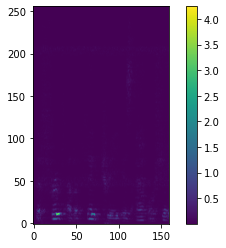

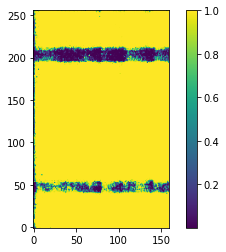

61 torch.Size([2, 12, 256, 160]) torch.Size([12, 256, 160])


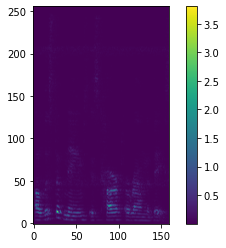

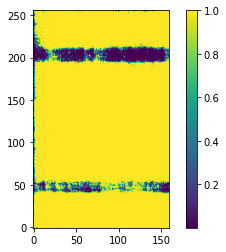

35 torch.Size([2, 12, 256, 160]) torch.Size([12, 256, 160])


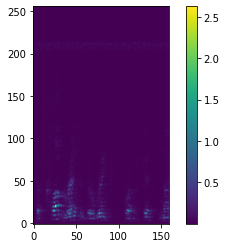

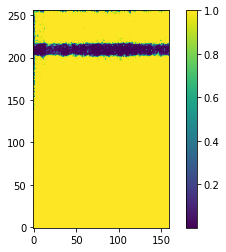

60 torch.Size([2, 12, 256, 160]) torch.Size([12, 256, 160])


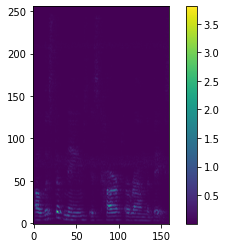

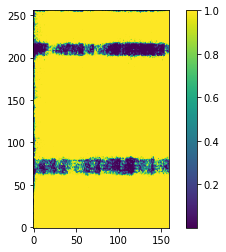

In [ ]:
fig = plt.figure()
rand_sampels = np.random.randint(low = 1,high = len(dataset), size=4)
for i in rand_sampels:
    [x,y] = dataset[i]

    print(i, x.shape, y.shape)

    plt.tight_layout()
    show_imag(x,0,0)
    show_SNR(y,0)

The code below uses PyTorch.DataLoader to assist in dividing the data set into  batches, which later will be fed into the model.

In [16]:
# dataloader training
dataloader_training = DataLoader(dataset=dataset,
                                batch_size=5,
                                shuffle=True)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_val,
                                  batch_size=1,
                                  shuffle=True)

[x,y] = next(iter(dataloader_training))

The Code below initializes the model and prints a summary of it.

In [17]:
model = DNN_model(in_channels=x.shape[1],
                 out_channels=y.shape[1],
                 n_blocks=3,
                 start_filters=32,
                 activation='leaky',
                 normalization='batch',
                 conv_mode='same',
                 dim=2 ,
                 depth = 12)
    
print(summary(model, ( x.shape)))

3.0
Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Down_3D_2D: 2-1                   [5, 4, 6, 256, 160]       --
|    |    └─Conv3d: 3-1                  [5, 4, 6, 256, 160]       508
|    |    └─LeakyReLU: 3-2               [5, 4, 6, 256, 160]       --
|    |    └─BatchNorm3d: 3-3             [5, 4, 6, 256, 160]       8
|    └─Down_3D_2D: 2-2                   [5, 8, 3, 256, 160]       --
|    |    └─Conv3d: 3-4                  [5, 8, 3, 256, 160]       1,160
|    |    └─LeakyReLU: 3-5               [5, 8, 3, 256, 160]       --
|    |    └─BatchNorm3d: 3-6             [5, 8, 3, 256, 160]       16
|    └─Down_3D_2D: 2-3                   [5, 16, 1, 256, 160]      --
|    |    └─Conv3d: 3-7                  [5, 16, 1, 256, 160]      3,472
|    |    └─LeakyReLU: 3-8               [5, 16, 1, 256, 160]      --
|    |    └─BatchNorm3d: 3-9             [5, 16, 1, 256, 160]      32
├─Mod

The code below initializes the trainer for our model. It consists the loss criterion, which is the MSE loss, the optimizer (Adam) and learning rate scheduler. The trainer receives the data loader and train the model. The trainer saves the model weights which acheived the lowest MSE on the validation set througout the training. It does that to avoid overfitting to the train data set.

In [18]:
# model
model.to(device)
# criterion
criterion = torch.nn.MSELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=scheduler,
                  epochs=40,
                  epoch=0,
                  notebook=True)

The code below uses the function Learning Rate Finder [12], to find an optimal learning rate and plots learning rate finder curve.

‏

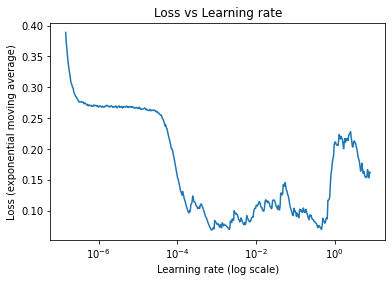

In [ ]:
fig_path = save_path + "LEARNING_CURVES_FINDER.png"
lrf = LearningRateFinder(model, criterion, optimizer, device,fig_path)
lrf.fit(dataloader_training, steps =500,min_lr=1e-7, max_lr=10)
fig = lrf.plot()

The code below start train the model, according to the trainer parameters.

In [19]:
# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()
torch.cuda.empty_cache()

Progress:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

The code below plots the learning curve and the learning rate curve, as a function of the epochs.

#<font color='red'>**This is just an example of a training process. the dataset used in this example is very small. Training on larger datasets will be presented next.**</font>

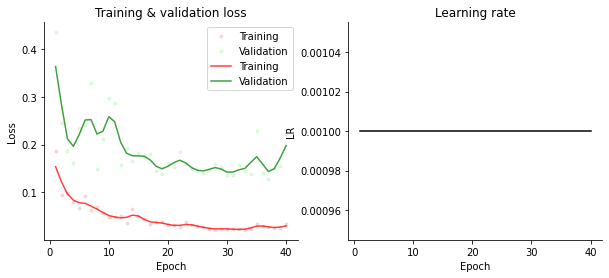

In [ ]:
#plot learinig curve
fig = plot_training(training_losses,
                validation_losses,
                lr_rates,
                gaussian=True,
                sigma=1,
                figsize=(10,4))
    

The code below save the best model, the last model and the learning curves.

In [ ]:
# save the model
model_name =  'stft2mask_last.pt'
torch.save(model, save_path + model_name)

model_name =  'stft2mask_best.pt'
torch.save(trainer.best_model, save_path + model_name)

fig_path = save_path + "learninig_curves.png"
fig.savefig(fig_path)

The code below performs prediction of our model on validation set, test set (which based on same noise of train set, but different desired signals) and test_rec set (which based on real world noise, with desired sources which taken from different data set of the train).

In [ ]:
#save masks of the best val model
# device

model_name = 'stft2mask_best.pt'
model = torch.load(save_path + model_name) #loading the entrie model

#########change!###########
file_name_val  = file_path + "data_val.mat"
file_name_test = file_path + "data_test.mat"
file_name_test_rec= file_path + "data_test_rec.mat"

###########################


dataset_val  = STFT2SNRDataset(mat_file= file_name_val, noise_per_sig = 10)
dataset_test = STFT2SNRDataset(mat_file= file_name_test, noise_per_sig = 10)
dataset_test_rec = STFT2SNRDataset(mat_file= file_name_test_rec, noise_per_sig = 10)
# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_val,
                                    batch_size=1,
                                    shuffle=False)
# dataloader test
dataloader_test = DataLoader(dataset=dataset_test,
                                    batch_size=1,
                                    shuffle=False)

# dataloader test rec
dataloader_test_rec = DataLoader(dataset=dataset_test_rec,
                                    batch_size=1,
                                    shuffle=False)

#Saving Validation masks
f_sample = dataset_val.desired[0].shape[0] -1
t_sample = dataset_val.desired[0].shape[1]
omega_sample = dataset_val.desired[0].shape[2]
num_of_masks = len(dataset_val)
masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
print("saving mask to",save_path)
for i_batch, [x,y] in enumerate(dataloader_validation):  
    mask_model = predict(x, model, device)
    mask_model = mask_model.cpu().numpy()
    masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



tmp_path = save_path + "masks_val_large.mat"
sio.savemat(tmp_path, {'masks': masks_out})

#Saving Test masks
f_sample = dataset_test.desired[0].shape[0] -1
t_sample = dataset_test.desired[0].shape[1]
omega_sample = dataset_test.desired[0].shape[2]
num_of_masks = len(dataset_test)
masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
print("saving mask to",save_path)
for i_batch, [x,y] in enumerate(dataloader_test):  
    mask_model = predict(x, model, device)
    mask_model = mask_model.cpu().numpy()
    masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



tmp_path = save_path + "masks_test_large.mat"
sio.savemat(tmp_path, {'masks': masks_out})


#Saving Test masks
f_sample = dataset_test_rec.desired[0].shape[0] -1
t_sample = dataset_test_rec.desired[0].shape[1]
omega_sample = dataset_test_rec.desired[0].shape[2]
num_of_masks = len(dataset_test_rec)
masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
print("saving mask to",save_path)
for i_batch, [x,y] in enumerate(dataloader_test_rec):  
    mask_model = predict(x, model, device)
    mask_model = mask_model.cpu().numpy()
    masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



tmp_path = save_path + "masks_test_rec_large.mat"
sio.savemat(tmp_path, {'masks': masks_out})



saving mask to /content/gdrive/.shortcut-targets-by-id/1b8L-TcAWUVSkXdLlervoeBYvWz1F3npN/DNN_Wiener//results/23_07_21/
saving mask to /content/gdrive/.shortcut-targets-by-id/1b8L-TcAWUVSkXdLlervoeBYvWz1F3npN/DNN_Wiener//results/23_07_21/
saving mask to /content/gdrive/.shortcut-targets-by-id/1b8L-TcAWUVSkXdLlervoeBYvWz1F3npN/DNN_Wiener//results/23_07_21/


#<font color='red'>**LONG RUNNING TIME, WE DO NOT RECOMMEND TO RUN THIS BOX BELOW**</font>

The code below parforms an ablation study of our model, with a learning rate 0.001, which we got from the learning Rate Finder, for all the scenarios. We do a parameter search of the following parameters:
* model 1: 3 U-Net layers, 32 filters of the first U-Net layer and batch size 35.
* model 2: 1 U-Net layer, 12 filters of the first U-Net layer and batch size 5.
* model 3: 5 U-Net layers, 12 filters of the first U-Net layer and batch size 50.
* model 4: 5 U-Net layers, 128 filters of the first U-Net layer and batch size 5.

In [ ]:


n_block = [3,1,5,5]
filters = [32,12,12,128]
b_s = [35,5,50,5]
lr_m = [0.001,0.001,0.001,0.001]
epochs_m = [100,100,100,100]
name = ["21_07_21_large_model4/"]

for i in range(len(n_block)):

    save_path = current_folder_path + "/results/" + name[i]

    try:
        os.mkdir(save_path)
    except OSError as error:
        print(error) 

    # dataloader training
    dataloader_training = DataLoader(dataset=dataset,
                                     batch_size=b_s[i],
                                     shuffle=True)
    # dataloader validation
    dataloader_validation = DataLoader(dataset=dataset_val,
                                       batch_size=1,
                                       shuffle=True)
    
    [x,y] = next(iter(dataloader_training))

    model = DNN_model(in_channels=x.shape[1],
                 out_channels=y.shape[1],
                 n_blocks=n_block[i],
                 start_filters=filters[i],
                 activation='leaky',
                 normalization='batch',
                 conv_mode='same',
                 dim=2 ,
                 depth = 12)
    
    print(summary(model, ( x.shape)))

    
    # model
    model.to(device)
    # criterion
    criterion = torch.nn.MSELoss()
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_m[i], betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    # trainer
    trainer = Trainer(model=model,
                      device=device,
                      criterion=criterion,
                      optimizer=optimizer,
                      training_DataLoader=dataloader_training,
                      validation_DataLoader=dataloader_validation,
                      lr_scheduler=scheduler,
                      epochs=epochs_m[i],
                      epoch=0,
                      notebook=True)
    # start training
    training_losses, validation_losses, lr_rates = trainer.run_trainer()
    torch.cuda.empty_cache()
    
    #plot learinig curve
    fig = plot_training(training_losses,
                   validation_losses,
                   lr_rates,
                   gaussian=True,
                   sigma=1,
                   figsize=(10,4))
    
    # save the model
    model_name =  'stft2mask_last.pt'
    torch.save(model, save_path + model_name)

    model_name =  'stft2mask_best.pt'
    torch.save(trainer.best_model, save_path + model_name)

    fig_path = save_path + "learninig_curves.png"
    fig.savefig(fig_path)




    #save masks of the best val model
    # device

    model_name = 'stft2mask_best.pt'
    model = torch.load(save_path + model_name) #loading the entrie model

    #########change!###########
    file_name_val  = file_path + "data_val.mat"
    file_name_test = file_path + "data_test.mat"
    file_name_test_rec= file_path + "data_test_rec.mat"

    ###########################


    dataset_val  = STFT2SNRDataset(mat_file= file_name_val, noise_per_sig = 10)
    dataset_test = STFT2SNRDataset(mat_file= file_name_test, noise_per_sig = 10)
    dataset_test_rec = STFT2SNRDataset(mat_file= file_name_test_rec, noise_per_sig = 10)
    # dataloader validation
    dataloader_validation = DataLoader(dataset=dataset_val,
                                       batch_size=1,
                                       shuffle=False)
    # dataloader test
    dataloader_test = DataLoader(dataset=dataset_test,
                                       batch_size=1,
                                       shuffle=False)

    # dataloader test rec
    dataloader_test_rec = DataLoader(dataset=dataset_test_rec,
                                       batch_size=1,
                                       shuffle=False)

    #Saving Validation masks
    f_sample = dataset_val.desired[0].shape[0] -1
    t_sample = dataset_val.desired[0].shape[1]
    omega_sample = dataset_val.desired[0].shape[2]
    num_of_masks = len(dataset_val)
    masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
    print("saving mask to",save_path)
    for i_batch, [x,y] in enumerate(dataloader_validation):  
        mask_model = predict(x, model, device)
        mask_model = mask_model.cpu().numpy()
        masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



    tmp_path = save_path + "masks_val_large.mat"
    sio.savemat(tmp_path, {'masks': masks_out})

    #Saving Test masks
    f_sample = dataset_test.desired[0].shape[0] -1
    t_sample = dataset_test.desired[0].shape[1]
    omega_sample = dataset_test.desired[0].shape[2]
    num_of_masks = len(dataset_test)
    masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
    print("saving mask to",save_path)
    for i_batch, [x,y] in enumerate(dataloader_test):  
        mask_model = predict(x, model, device)
        mask_model = mask_model.cpu().numpy()
        masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



    tmp_path = save_path + "masks_test_large.mat"
    sio.savemat(tmp_path, {'masks': masks_out})


    #Saving Test masks
    f_sample = dataset_test_rec.desired[0].shape[0] -1
    t_sample = dataset_test_rec.desired[0].shape[1]
    omega_sample = dataset_test_rec.desired[0].shape[2]
    num_of_masks = len(dataset_test_rec)
    masks_out = np.zeros((num_of_masks,omega_sample,f_sample,t_sample))
    print("saving mask to",save_path)
    for i_batch, [x,y] in enumerate(dataloader_test_rec):  
        mask_model = predict(x, model, device)
        mask_model = mask_model.cpu().numpy()
        masks_out[i_batch,:,:,:] = mask_model[0,:,:,:]



    tmp_path = save_path + "masks_test_rec_large.mat"
    sio.savemat(tmp_path, {'masks': masks_out})




# Results

We conduct an ablation study which examines the impact of the train data size and the parameters of our model.

1. **Train data size:**
In order to check the influence of the data size, we run our model according to the following diagram:

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=16lDAj-IIFG8v3ULmNDa9AZA_Uss_0Rgp' />
<figcaption>Train data size diagram</figcaption></center>
</figure>

We chose the best model based on the resulting plots below and based explicitly on the rec_test set, which is the most strict model (based on real noise).

The best model performance was for the large train data set, as expected. 


Note - learning curves and prediction results for small and mid-data sets appear in the appendix.


For the **large data set:**

**Learning curve for the large data set:**

![](https://drive.google.com/uc?export=view&id=1Kv35aLgNCu7qxfXrimheftQDc8y876Hj)

We can see that from the learning curve that the loss value decreases in each subsequent iteration. It also reaches a minimal loss value of 0.02, which is the lowest loss value compared to the minimum values for the mid and small data set. (see appendix).

**Prediction results and comparison to SOTA method (DD):**

**Test set:**

MSE:

![](https://drive.google.com/uc?export=view&id=1AEhROZwK1iko10I9vBrwO9G7Y09htYU7)

We can see that the MSE of our method (DNN) is much lower than the DD method.

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1_kQqUxIBlUOwDh7LoBGgIFkEFiZcUZfv)

We can see the our SDR is lower than the SDR of DD.

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1-Gdu6vVyPZr6WtJIjNUA1dElZjk9wtkf)

We can see that our noise gain is significantly much lower than the noise gain of DD, and it is much closer to the noise gain of the true Wiener mask.

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1l9Lbu2jZRYZsGdRgjAVFLVaPZXqn6jp6)

We can see that our mask closely matches to the true Wiener mask and less "noisy" that the DD mask. We also observe that our makes the noise "smoother".

**Test_rec set:**

MSE:

![](https://drive.google.com/uc?export=view&id=1OMhpKgf2IQJCg5BqZ1QeYNBZv_yyMTNR)

We can see that the MSE of our method is very close to the MSE of DD. Additionally, it is also higher than the MSE for the test set. The reason is that the noises of the test_rec set are real-world noises, which our model did not learn. 

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1blvogDD6C75LCuZqaRoU47LSBwScnKP6)

We can see that the SDR of our method is higher than the one of the test set.

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1gZYGDcB8sfyANoK7hrl7dgHiy8rI1DuY)

The noise gain is higher than the one of the test_rec, and the gap between the noise gain of DD and our method is getting smaller.

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1ENg6ekYAtoo1MaUKZ5UEjl2uBKZHltD2)



2. **Optimal values for hyper-parameters:**
Here we choose the optimal learning rate, batch size, number of layers and number of filters of U-Net, according the the following diagram:

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1WTq9YJ1ohUxg0QSSZBQsHU__icYojQEu' />
<figcaption>Optimal values for hyper-parameters diagram</figcaption></center>
</figure>

We chose the best model based on the results of the test_rec set, as we did in the train data size.

The optimal parameters:
* 5 layers
* 128 filters
* batch size = 5
* learning rate = 0.001

Note - Learning curves and prediction results for the other parameter sets in the diagram above appear in the appendix.

For the **optimal set of parameters**:

**Learning curve for the optimal parameter set:**

![](https://drive.google.com/uc?export=view&id=1HB4bJZw3EjIpY4mH6BxCWHTxXGdrlIuQ)

We can see that the learning curve for the validation set is stable from around 40 iterations and that the loss decreases in each iteration.

**Learning Rate finder curve for the optimal parameter set:**

![](https://drive.google.com/uc?export=view&id=1W2Xr28f47HxYgR0vjonBvKRc7lyBHCK-)

Here we chose the optimal learning rate according to [12] in the following manner: we choose a learning rate that is a bit smaller than the learning rate, which minimizes the curve above to get maximal stability. We can see that the minimum value is for a learning rate of 0.01, so we choose a learning rate equal to 0.001.

**Prediction results and comparison to SOTA method (DD):**

**Test set:**

Here the results are similar to the large data train, except for the signal distortion, which is high than the DD method, but the difference is insignificant.

MSE:

![](https://drive.google.com/uc?export=view&id=1zOuGBGdgXo9xhSBIiPI_kH4L5V-OCVRb)

Signal distortion:

![](https://drive.google.com/uc?export=view&id=18iNtfIHlbcc2RVl6SPHq5yMXcV3AFTnr)

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1dbFdgSdLzHXzF9M-V5ifyfUojQLMrxjV)

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1mAx6zpGyIk4jhQmtXWndVp8uuttrZCbw)

**Test_rec set:**

MSE:

![](https://drive.google.com/uc?export=view&id=1LnaRqpFo4HfozSuMYdHScHRS6wgt9k8r)

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1JfGtOz3TBcLr9Z3k_HRMe4uL2zy1xK0u)

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=110UyGgd6EBacPa7O4Ev98FffT-nRSa7a)

We can see here that the noise gain is slightly higher than the noise gain of DD, but it is better than the other noise reductions for the other scenarios we have checked. 

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1pXgap7lU52OOdKGyR3F4IlFekfdIR92Y)


3. Combine large data set and optimal hyper-parameters
Here we can see graphs for the model with large train data set and the optimal parameters we found:

**Learning curve for the optimal train data set & optimal parameter set:**

![](https://drive.google.com/uc?export=view&id=1XzgwBpi02SYsT__NQzgN9VIhQvEMa0vO)

We can see that the learning curve for the train set is lower than 0.02. (the lowest we got from all our trained models). We can also see that the loss for the validation set is minimal around epoch 20, which means we could stop the training procedure much sooner. Our final model was the one that got the minimum loss value for the validation set.

**Prediction results and comparison to SOTA method (DD):**

**Test set:**

MSE:

![](https://drive.google.com/uc?export=view&id=1sXzO0sKUHzGdwwZSPRvORzhIi7XZGPR2)

We can see that our method outperforms the DD method in the MSE sense, for the test set.

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1uE5TvcI9ThUur4OG4O6xrSD1n1-Bos79)

The SDR closely matches to the SDR of DD.

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1NUeWjVMG_TLb1kgrGOhKMarNvn32rsIU)

We can see noise gain very low and close to the true Wiener noise gain.

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1Yru15lCDgbdqCDV1tCJb6jkp0g7mSQSQ)


**Test_rec set:**

MSE:

![](https://drive.google.com/uc?export=view&id=1uPcnEv884RTbsX9PkehjRsF-YHy0tklh)

We can see that both the MSE's closely match.

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1n0c3OzJz-tOAkfl_eyhVOF-gJ7m5sbAS)

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1HC-gc9G4pqMPejgEuI31S-W9e4pwFPEg)

We can see that both the SDR and the noise gain are lower than the ones of the DD method.

An example of the output (mask):

![](https://drive.google.com/uc?export=view&id=1T8fbLvlPzvh_Tbes_GRdTO41DjQIqUbr)


#Listening Exampels
The following code boxes contain some binaural signals that you can listen to. 

The estimation of the wiener masks is performed with the last model presents in the results section.

#<font color='red'>**It is importent to only listen with headphones! at a reasonably high volume**</font>




The following examples feature an example taken from the test_rec set. The noise is a real recording of industrial fan noise

**note how the benchmark signal results in added musical noise, which is very perceptually noticeable**

In [20]:
binaural_sound_path = current_folder_path + "/sound_exampels/model4_long_train_test_rec/13/"
current_example_name = binaural_sound_path + "noisy_input.wav"
print("Alg input: Noisy signal - recorded noise")
IPython.display.Audio(current_example_name)


Alg input: Noisy signal - recorded noise


In [ ]:
current_example_name = binaural_sound_path + "clean_output.wav"
print("Clean signal - recorded noise")
IPython.display.Audio(current_example_name)

Clean signal - recorded noise


In [ ]:
current_example_name = binaural_sound_path + "DD_output.wav"
print("Banchmark signal - recorded noise")
IPython.display.Audio(current_example_name)

Banchmark signal - recorded noise


In [ ]:
current_example_name = binaural_sound_path + "DNN_output.wav"
print("Our model signal - recorded noise")
IPython.display.Audio(current_example_name)

Our model signal - recorded noise


The following examples feature an example taken from the test set. The noise is a full bandwidth white noise


In [ ]:
binaural_sound_path = current_folder_path + "/sound_exampels/model4_long_train_test/72/"
current_example_name = binaural_sound_path + "noisy_input.wav"
print("Alg input: Noisy signal - simulated noise")
IPython.display.Audio(current_example_name)

Alg input: Noisy signal - simulated noise


In [ ]:
current_example_name = binaural_sound_path + "clean_output.wav"
print("Clean signal - simulated noise")
IPython.display.Audio(current_example_name)

Clean signal - simulated noise


In [ ]:
current_example_name = binaural_sound_path + "DD_output.wav"
print("Banchmark signal - simulated noise")
IPython.display.Audio(current_example_name)

Banchmark signal - simulated noise


In [ ]:
current_example_name = binaural_sound_path + "DNN_output.wav"
print("Our model signal - recorded noise")
IPython.display.Audio(current_example_name)

Our model signal - recorded noise


# Result analysis
From the ablation study, we learned:
* Deeper is, in fact, better. The best performing model we tested (due to finite GPU memory constraints) was the one with the overall highest number of trainable parameters (~124 Million). 
* The model generalizes better the more extensive the dataset is. For example, as the dataset represented a "richer" (white\pink noise, full-band\finite-band) noise distribution, the model could better handle real-life recorded noise sources.
* Using the learning rate finder, we learn that the model architecture did not affect the preferred learning rate (which was 0.001).
* Using a learning rate scheduler that lowered the learning rate when the validation loss stopped improving help fine-tune the convergence.
* Using a validation loss monitor during the training helped us avoid overfitting the model to the train set since only the epoch which achieved the lowest MSE on the validation set was saved (not the last iteration).

# Conclusions

In conclusion, we have developed a novel method for Wiener mask estimation using a deep neural network. The work includes:
* Generating a rich data set for the train set and test sets: test set, which is based on the same noise distribution as in the train set (but different speakers from train set), and test_rec set, which is based on real-world recorded noise.
* We overcome the storage limitation by mapping pairs of desired and undesired signals with a dataset loader. The mapping allows to significantly increase the available datapoints while maintaining a relatively low memory usage.
* Adapting the U-Net architecture to fit our task.
* We used a learning rate finder method [12] to find an initial learning rate, which was later lowered during training by a learning rate scheduler.
* We conducted an ablation study in which several architecture sizes and various batch sizes were tested. The best-performing model was selected according to the metrics we defined in the Benchmark section.
* Implementing the SOTA method DD, which we compare to our method. 
* We have shown that our method outperforms the state-of-the-art method (DD) under the settings we described in the Datasets section. We note that our method has high performance for the test_rec set, which is the most strict test because our model did not learn real-world noises. It is essential to say that the SOTA method relies on the assumption that a-priori information of the noise is available. Our method does not rely on any information on the noise, and therefore it is much practical. 

As further research, other scenario parameters can be changed, such as the room parameters, STFT parameters, and the number of microphones in the array. 

# Appendix

**1. Train data size:**

* Small data set:

**Learning curve:**

![](https://drive.google.com/uc?export=view&id=1zuzM2m-JWkqjtPrqA8eZI0wMKmyZX4k_)

**Prediction results and comparison to SOTA method (DD):**

Test set:

MSE:

![](https://drive.google.com/uc?export=view&id=1TZmoUPpFCdZhxHXumXGhU_uLKhHMiP4v)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=10LG6lNwcoxbAZVKz89QTmYJwbO2kCIto)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1eFgoeZTARNn4Kv-ZVUrVznlC3rLy2bh2)


Test_rec set:

MSE:

![](https://drive.google.com/uc?export=view&id=1jm11sPS7Ce5nTwk2M_ZZBlN9noST-zGK)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1WtsEj69lC6rtIlYxKxrEUvjsoSHpjQM4)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1EDmz9nkL7uUkGL0Ql8p_mFjkfgOxezjh)


* Mid data set:

**Learning curve:**

![](https://drive.google.com/uc?export=view&id=17tTVGTgNRyZD42JeKf3KPSWJqGzzdq4P)

**Prediction results and comparison to SOTA method (DD):**

Test set:

MSE:

![](https://drive.google.com/uc?export=view&id=1wGSEuWEmdZPtKO3o0Fa83Gm6Mfi6bHf9)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1R7yDorRtXGJpBrmP8nKEcowS-Tn70TcS)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1bsE3pwRnKMOpCPy0154FFOJDZLd3Q0KY)

Test_rec set:

MSE:

![](https://drive.google.com/uc?export=view&id=1qg2LM22RAYVwF2tUA-lSJTow5On3N-FP)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1oJr9IVZarSHHDa6oKyFiyro59BNe_rMo)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1TGqLJ66lmDK-n1P0XnK-dn7pa5NWAuC2)


**2. Optimal values for hyper-parameters:**

* Block number=3, start filters number=32, batch size=35, lr=0.001

**Learning curve:**

![](https://drive.google.com/uc?export=view&id=1OIKrIpEKqyPNfjF6wzycTOWkVdc4gQHY)

**Learning rate finder curve:**

![](https://drive.google.com/uc?export=view&id=1FoVJpCASSZr56kY1w3_R0OIZyMsVs60j)

**Prediction results and comparison to SOTA method (DD):**

Test set:

MSE:

![](https://drive.google.com/uc?export=view&id=1ucHxnTkgPfLicp_-uY2Ztz_22AJZgXtj)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1p498SXJKzya3jWK2zkH--9RDFhg53gB4)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1Ve7ZOcxIgRaB_v-YZiTUTZW5SPgneGJq)


Test_rec set:

MSE:

![](https://drive.google.com/uc?export=view&id=1WybXpt4txKN9mO0bHXF8-iEcWKRocL1x)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1e5uu-kme1FfU-5gcKpAx2fMw7jgMW5_n)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1tFxmHvVnkML-rA99CK5T5vlxEHRuo-hQ)


* Block number=1, start filters number=12, batch size=5, lr=0.001

**Learning curve:**

![](https://drive.google.com/uc?export=view&id=1OuHPFVA_T0jY5sFuoInhYBEjVY7dXD-p)

**Learning rate finder curve:**

![](https://drive.google.com/uc?export=view&id=1t3NoL_JrMXVWL5RVQnta16RUuha5pWT8)

**Prediction results and comparison to SOTA method (DD):**

Test set:

MSE:

![](https://drive.google.com/uc?export=view&id=10mBH4fQs2bfw_fTb-ZVyaxHZhBaNQZbT)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1H2R53OMl-2c9CKCzRWP0D-oES-TE-jku)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1l6_MYGamy_k4arTcTGa3VFPOtdOGFckr)


Test_rec set:

MSE:

![](https://drive.google.com/uc?export=view&id=1sKxGwPvr6Y0XDYG9U9sIDE_KjxxpPjnh)


Signal distortion:

![](https://drive.google.com/uc?export=view&id=1FJx1PhzBPIwMl5O3Xfvpyz6yrlty07cn)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1M2jermhwhuIP95K7yWpQoi0ZZDTAwM2_)


* Block number=5, start filters number=12, batch size=50, lr=0.001

**Learning curve:**

![](https://drive.google.com/uc?export=view&id=1hTkfJ5rvYOW99-bvqi4J7DynkgBn5Kfe)

**Learning rate finder curve:**

![](https://drive.google.com/uc?export=view&id=1SqtIste-Ghhqkhsv58jgRl4hypO_m5oX)

**Prediction results and comparison to SOTA method (DD):**

Test set:

MSE:

![](https://drive.google.com/uc?export=view&id=1W7MWBa0YtD9PMFM0PQwhb1PSYNS4vzUE)

Signal distortion:

![](https://drive.google.com/uc?export=view&id=1jqgOqTdKG0r3StnHc9f7NqckXx5UZWkV)


Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1oXWJpegB6_S25vWZeAi81ArOgJC2iKp3)


Test_rec set:

MSE:

![](https://drive.google.com/uc?export=view&id=137Qg_Uy2E1_2qi8baNnh6uPJVZL_sbu9)

Signal distortion:

![](https://drive.google.com/uc?export=view&id=192gFaosC14IWoghj9j-UDop5b5cZQyv9)

Noise (gain) reduction:

![](https://drive.google.com/uc?export=view&id=1BWpEydYYub48-gkmCXFjJ_4i1KWsK0AD)



# References

[1] PERRY, Tekla S. Virtual reality goes social. IEEE Spectrum, 2015, 53.1: 56-57.

[2] Moore, C. L. "The Virtual Yellow House: Experimental tangling with virtual reality," IEEE Consumer Electronics Magazine 5 .4 (2016): 103-104.

[3] Doclo, S., Gannot, S., Moonen, M., & Spriet, A. (2010). Acoustic Beamforming for Hearing Aid Applications.

[4] Rafaely, Boaz. "Analysis and design of spherical microphone arrays." IEEE Transactions on speech and audio processing 13.1 (2004): 135-143.‏

[5] M. Lugasi and B. Rafaely, "Speech Enhancement Using Masking for Binaural Reproduction of Ambisonics Signals," in IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 28, pp. 1767-1777, 2020, doi: 10.1109/TASLP.2020.2998294.

[6] Abend, Uri, and Boaz Rafaely. "Spatio-spectral masking for spherical array beamforming." 2016 IEEE International Conference on the Science of Electrical Engineering (ICSEE). IEEE, 2016.‏

[7] D. Khaykin and B. Rafaely, "Coherent signals direction-of-arrival estimation using a spherical microphone array: Frequency smoothing approach," 2009 IEEE Workshop on Applications of Signal Processing to Audio and Acoustics, 2009, pp. 221-224, doi: 10.1109/ASPAA.2009.5346492.

[8] Rafaely, Boaz. Fundamentals of spherical array processing. Vol. 16. Springer, 2018.‏‏

[9] Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for semantic segmentation." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.‏

[10] Ephraim, Yariv, and David Malah. "Speech enhancement using a minimum-mean square error short-time spectral amplitude estimator." IEEE Transactions on acoustics, speech, and signal processing 32.6 (1984): 1109-1121.‏

[11] Herzog, Adrian, and Emanuël AP Habets. "Direction preserving wiener matrix filtering for ambisonic input-output systems." ICASSP 2019-2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP). IEEE, 2019.‏

[12] Smith, Leslie N. "Cyclical learning rates for training neural networks." 2017 IEEE winter conference on applications of computer vision (WACV). IEEE, 2017.

[13] Paul, Douglas B., and Janet Baker. "The design for the Wall Street Journal-based CSR corpus." Speech and Natural Language: Proceedings of a Workshop Held at Harriman, New York, February 23-26, 1992. 1992.

[14] Kabal, Peter. "TSP speech database." McGill University, Database Version 1.0 (2002): 09-02.
